In [1]:
from jax_circuits import*
from topology import *
from penalty import *
from cp_utils import *
import matplotlib.pyplot as plt
from scipy.stats import unitary_group
from qiskit import transpile
from qiskit.quantum_info import Operator
import pickle
import time

# Learning random unitaries

In [38]:
%%time
u_target = unitary_group.rvs(8, random_state=131)
anz = Ansatz(3, 'cz', placements=fill_layers(sequ_layer(3), 14))

res_no_hist = anz.learn(u_target, learning_rate=0.1, num_iterations=2000, num_repeats=10, keep_history=False)

# plt.plot(res['loss'])
# plt.yscale('log')

CPU times: user 21.2 s, sys: 16 ms, total: 21.2 s
Wall time: 21.2 s


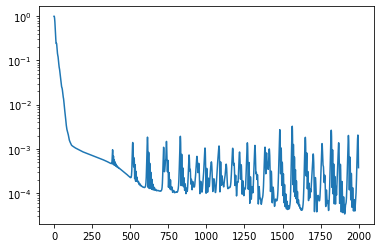

In [39]:
plt.plot(res_hist[1]['loss'])
plt.yscale('log')

In [40]:
%%time
u_target = unitary_group.rvs(8, random_state=131)
anz = Ansatz(3, 'cz', placements=fill_layers(sequ_layer(3), 14))

res_hist = anz.learn(u_target, learning_rate=0.1, num_iterations=2000, num_repeats=10, keep_history=True)

# plt.plot(res['loss'])
# plt.yscale('log')

CPU times: user 20.4 s, sys: 16 ms, total: 20.4 s
Wall time: 20.4 s


In [41]:
for rh, rnh in zip(res_hist, res_no_hist):
    print(jnp.min(rh['loss']), jnp.min(rnh['loss']))

2.0384789e-05 2.0384789e-05
3.4093857e-05 3.4093857e-05
7.867813e-06 7.867813e-06
0.0002863407 0.0002863407
5.00679e-06 2.861023e-06
2.7418137e-06 2.7418137e-06
0.00016379356 0.00016379356
1.0609627e-05 1.0609627e-05
2.7418137e-06 2.7418137e-06
-4.7683716e-07 -4.7683716e-07


In [36]:
for rh, rnh in zip(res_hist, res_no_hist):
    print(jnp.min(rh['loss']), jnp.min(rnh['loss']))

2.0384789e-05 2.0384789e-05
3.4093857e-05 3.4093857e-05
7.867813e-06 7.867813e-06
0.0002863407 0.0002863407
5.00679e-06 2.861023e-06
2.7418137e-06 2.7418137e-06
0.00016379356 0.00016379356
1.0609627e-05 1.0609627e-05
2.7418137e-06 2.7418137e-06
-4.7683716e-07 -4.7683716e-07


In [42]:
# for rh, rnh in zip(res_hist, res_no_hist):
#     print(jnp.allclose(rh['params'][jnp.argmin(rh['loss'])], rnh['params'][jnp.argmin(rnh['loss'])], atol=1e-0))
#     print(rh['params'][jnp.argmin(rh['loss'])])
#     print(rnh['params'][jnp.argmin(rnh['loss'])])

In [31]:
iteration_without_history(0, [params, best_params, loss, best_loss, opt_state])

(DeviceArray([0., 1.], dtype=float32),
 DeviceArray([1., 2.], dtype=float32),
 DeviceArray(1., dtype=float32),
 DeviceArray(0.05, dtype=float32),
 [ScaleByAdamState(count=DeviceArray(1, dtype=int32), mu=DeviceArray([0., 0.], dtype=float32), nu=DeviceArray([0., 0.], dtype=float32)),
  EmptyState()])

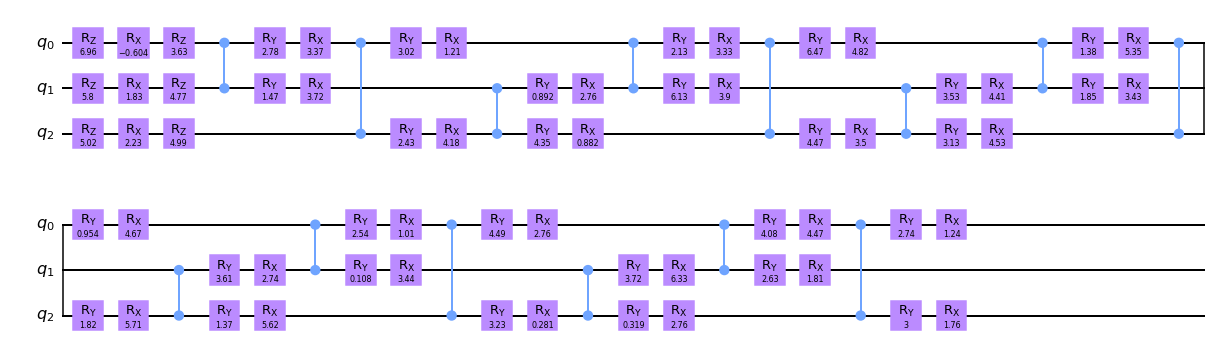

In [12]:
anz.circuit(res['params'][-1]).draw(output='mpl')

# Local minumums

3q unitaries

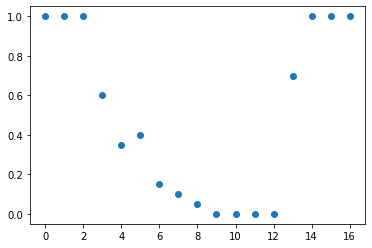

In [4]:
min_depth=0
max_depth = theoretical_lower_bound(3)+2
with open('data/success_rates_3.pickle', 'rb') as f:
     success_rates = pickle.load(f)
        
plt.scatter(range(min_depth, max_depth+1), success_rates)

Toffoli 3

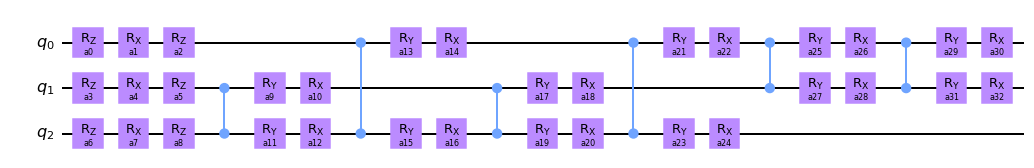

In [2]:
qc = QuantumCircuit(3)
qc.ccx(0, 1, 2)
u_toff3 = Operator(qc.reverse_bits()).data

placements_toff3 = [[1, 2], [0, 2], [1, 2], [0, 2], [0, 1], [0, 1]]
anz_toff3 = Ansatz(3, 'cz', placements={'free': placements_toff3})

anz_toff3.circuit().draw(output='mpl')

Learning from random initial angles is about 80% likely to get stuck in local minimum.

In [4]:
%%time
res = anz_toff3.learn(u_toff3, num_repeats=20)
success_hist = [jnp.min(r['loss'])<1e-4 for r in res]
print(sum(success_hist)/len(success_hist))

0.15
CPU times: user 18.6 s, sys: 19.8 ms, total: 18.7 s
Wall time: 18.6 s


4q unitaries

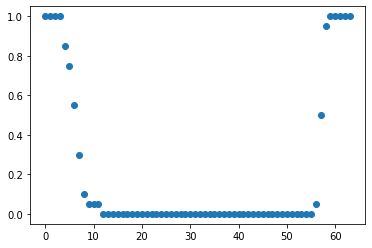

In [7]:

































савmin_depth=0
max_depth = theoretical_lower_bound(4)+2
with open('data/success_rates_4.pickle', 'rb') as f:
     success_rates = pickle.load(f)
        
plt.scatter(range(min_depth, max_depth+1), success_rates)

In [3]:
%%time
qc = QuantumCircuit(4)
qc.mct([0, 1, 2], 3)
u_toff4 = Operator(qc.reverse_bits()).data

placements_toff4 = [[0, 1], [0, 1], [1, 2], [0, 2], [1, 2], [0, 2], [2, 3], [1, 3], [2, 3], [0, 3], [2, 3], [1, 3], [2, 3], [0, 3]]
anz_toff4 = Ansatz(4, 'cz', placements={'free': placements_toff4})

res = anz_toff4.learn(u_toff4, num_repeats=1000, keep_history=False)
success_hist = [jnp.min(r['loss'])<1e-4 for r in res]
print(sum(success_hist)/len(success_hist))

0.007
CPU times: user 11min 38s, sys: 5.15 s, total: 11min 43s
Wall time: 9min 51s


![get_stuck](daddy_pig.jpg)

https://youtu.be/keRKOv1Z9PA?t=82

# CP circuits

## Penalty function

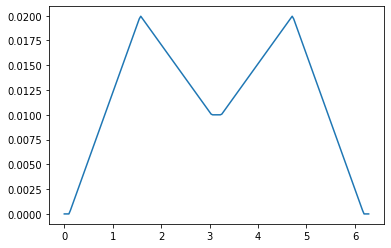

In [12]:
reg_options = {'r': 0.001,
               'function': 'linear',
               'ymax': 2,
               'xmax': jnp.pi/2,
               'plato': 0.1,
               'num_gates': 7,
               'angle_tolerance': 0.2,
               'cp_mask': anz.cp_mask}

pen_f = construct_penalty_function(reg_options)
a_sweep = jnp.linspace(0,2*jnp.pi, 200)
plt.plot(a_sweep, vmap(jit(pen_f))(a_sweep))

## Toffoli 3

Connected topology, zero initial CP angles.

In [2]:
qc = QuantumCircuit(3)
qc.ccx(0, 1, 2)
u_toff3 = Operator(qc.reverse_bits()).data

anz = Ansatz(3, 'cp', fill_layers(sequ_layer(3), 10))

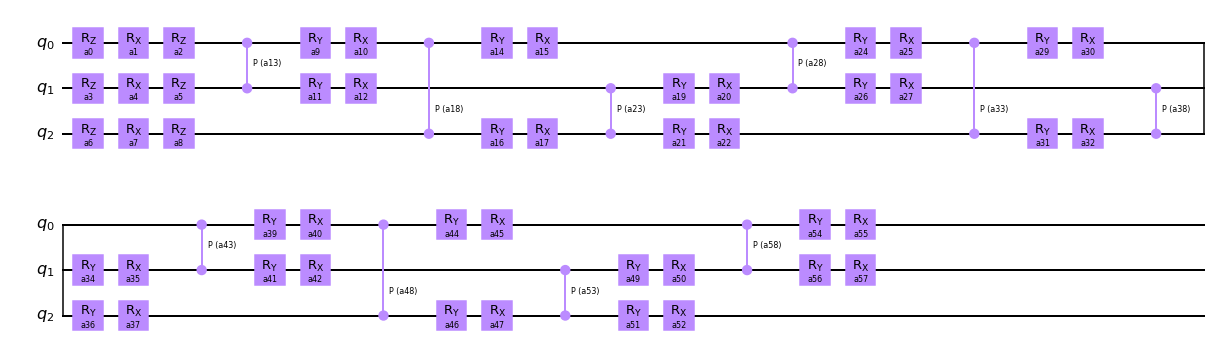

In [3]:
anz.circuit().draw(output='mpl')

In [2]:
qc = QuantumCircuit(3)
qc.ccx(0, 1, 2)
u_toff3 = Operator(qc.reverse_bits()).data

anz = Ansatz(3, 'cp', fill_layers(sequ_layer(3), 10))

reg_options = {'r': 0.001,
               'function': 'linear',
               'ymax': 2,
               'xmax': jnp.pi/2,
               'plato': 0.05,
               'num_gates': 5,
               'angle_tolerance': 0.2,
               'cp_mask': anz.cp_mask}

key = random.PRNGKey(2)
num_samples = 20

time_start = time.time()
successful_results, failed_results = cp_decompose(u_toff3, 
                                               anz,
                                               regularization_options=reg_options,
                                               num_samples=num_samples, 
                                               key=key,
                                               disc_func=disc2,
                                               cp_dist='0',
                                               save_to='toff3_connected')

print(len(successful_results)/num_samples)
print(f'time: {time.time()-time_start}')


Computing raw results.

Selecting prospective results:


20it [00:00, 97.56it/s] 


0 found.

Verifying prospective results:


0it [00:00, ?it/s]

0 successful.
cz counts are:
[]
0.0
time: 31.567753553390503


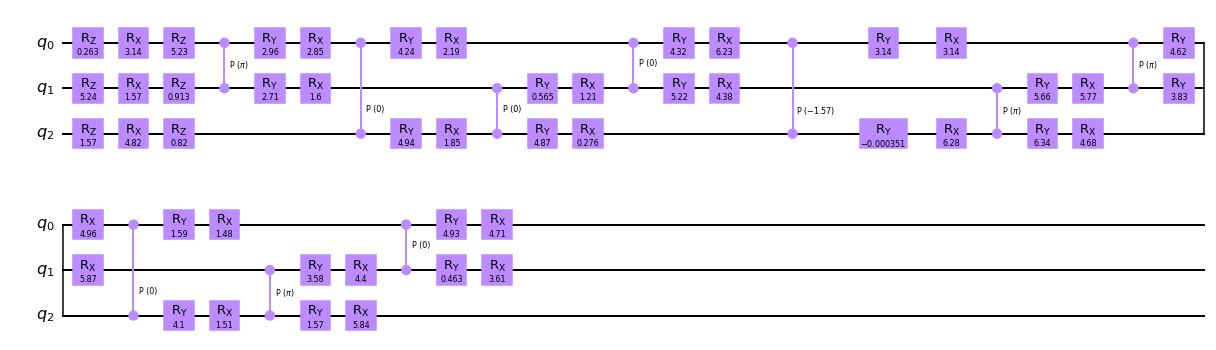

In [31]:
cz, circ, u, angles = successful_results[1]
circ(angles).draw(output='mpl')

Connected topology, random initial CP angles.

In [32]:
qc = QuantumCircuit(3)
qc.ccx(0, 1, 2)
u_toff3 = Operator(qc.reverse_bits()).data

anz = Ansatz(3, 'cp', fill_layers(sequ_layer(3), 10))

reg_options = {'r': 0.001,
               'function': 'linear',
               'ymax': 2,
               'xmax': jnp.pi/2,
               'plato': 0.05,
               'num_gates': 7,
               'angle_tolerance': 0.2,
               'cp_mask': anz.cp_mask}

key = random.PRNGKey(2)
num_samples = 20

successful_results, failed_results = cp_decompose(u_toff3, 
                                               anz,
                                               regularization_options=reg_options,
                                               num_samples=num_samples, 
                                               key=key,
                                               disc_func=disc2,
                                               cp_dist='uniform',
                                               save_to='toff3_connected')


Computing raw results.


100%|██████████| 20/20 [00:48<00:00,  2.41s/it]



Selecting prospective results:


20it [00:00, 87.46it/s]


5 found.

Verifying prospective results:


100%|██████████| 5/5 [00:57<00:00, 11.53s/it]


5 successful.
cz counts are:
[6, 7, 7, 6, 7]


Chain topology (notably, there was a single successful results at 12 gates).

In [36]:
qc = QuantumCircuit(3)
qc.ccx(0, 1, 2)
u_toff3 = Operator(qc.reverse_bits()).data

anz = Ansatz(3, 'cp', fill_layers(chain_layer(3), 14))

reg_options = {'r': 0.001,
               'function': 'linear',
               'ymax': 2,
               'xmax': jnp.pi/2,
               'plato': 0.05,
               'num_gates': 9,
               'angle_tolerance': 0.2,
               'cp_mask': anz.cp_mask}

key = random.PRNGKey(2)
num_samples = 50

successful_results, failed_results = cp_decompose(u_toff3, 
                                               anz,
                                               regularization_options=reg_options,
                                               num_samples=num_samples, 
                                               key=key,
                                               disc_func=disc2,
                                               cp_dist='0',
                                               save_to='toff3_connected')


Computing raw results.


100%|██████████| 50/50 [01:33<00:00,  1.87s/it]



Selecting prospective results:


50it [00:00, 84.60it/s]


5 found.

Verifying prospective results:


100%|██████████| 5/5 [00:42<00:00,  8.58s/it]


5 successful.
cz counts are:
[8, 8, 9, 9, 8]


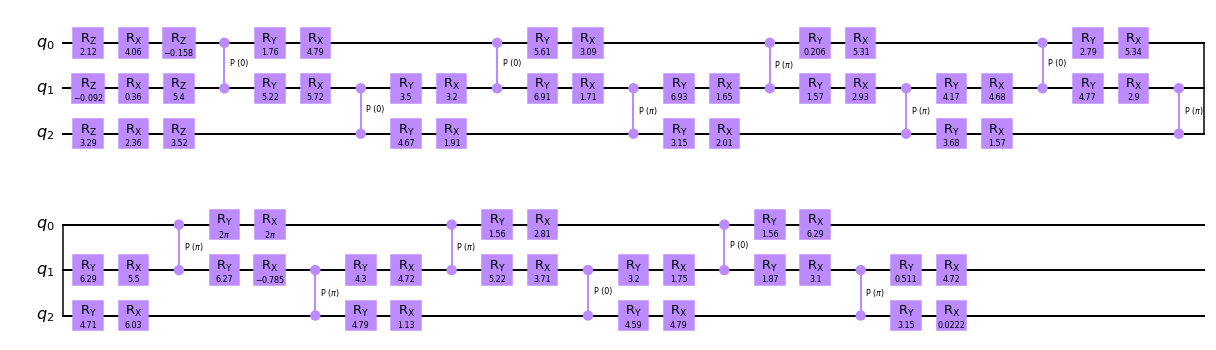

In [37]:
cz, circ, u, angles = successful_results[0]
circ(angles).draw(output='mpl')

## Toffoli 4

Connected topology.

In [4]:
import time
start_time = time.time()
qc = QuantumCircuit(4)
qc.mct([0, 1, 2], 3)
u_toff4 = Operator(qc.reverse_bits()).data


anz = Ansatz(4, 'cp', fill_layers(sequ_layer(4), 24))

reg_options = {'r': 0.001,
               'function': 'linear',
               'ymax': 2,
               'xmax': jnp.pi/2,
               'plato': 0.05,
               'num_gates': 18,
               'cp_mask': anz.cp_mask}

key = random.PRNGKey(131)

num_samples = 20

successful_results, failed_results = cp_decompose(u_toff4, 
                                               anz,
                                               regularization_options=reg_options,
                                               num_samples=num_samples, 
                                               key=key,
                                               disc_func=disc2,
                                               cp_dist='0',
                                               save_to='toff4_connected')

print("For version with compiled f:", time.time() - start_time)


Computing raw results.

Selecting prospective results:


20it [00:00, 77.36it/s]


2 found.

Verifying prospective results:


100%|██████████| 2/2 [03:41<00:00, 110.96s/it]


2 successful.
cz counts are:
[18, 18]
For version with compiled f: 293.185218334198


Chain topology (uniform with the same settings found zero, hm).

In [ ]:
qc = QuantumCircuit(4)
qc.mct([0, 1, 2], 3)
u_toff4 = Operator(qc.reverse_bits()).data


anz = Ansatz(4, 'cp', fill_layers(chain_layer(4), 40))

reg_options = {'r': 0.0015,
               'function': 'linear',
               'ymax': 2,
               'xmax': jnp.pi/2,
               'plato': 0.05,
               'num_gates': 18,
               'cp_mask': anz.cp_mask}

key = random.PRNGKey(130)

num_samples = 1000

successful_results, failed_results = cp_decompose(u_toff4, 
                                               anz,
                                               regularization_options=reg_options,
                                               num_samples=num_samples, 
                                               key=key,
                                               disc_func=disc2,
                                               cp_dist='uniform',
                                               save_to='toff4_chain')


Computing raw results.


In [9]:
def ff(a_b):
    a, b = a_b
    return [a+b, a*b]

In [27]:
res = vmap(ff)(jnp.array([[1, 2], [3, 4], [5,6]]))

In [28]:
list(zip(res[0], res[1]))

[(3, 2), (7, 12), (11, 30)]

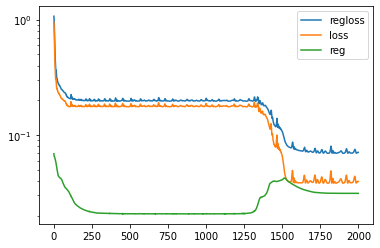

In [61]:
with open('data/toff4_chain_raw_results.pickle', 'rb') as f:
    raw_results = pickle.load(f)
_,_ = report_cp_learning(raw_results[100])

# Leaving CP angles arbitrary

In [63]:
qc = QuantumCircuit(3)
qc.ccx(0, 1, 2)
u_toff3 = Operator(qc.reverse_bits()).data

anz = Ansatz(3, 'cp', fill_layers(sequ_layer(3), 10))

reg_options = {'r': 0.001,
               'function': 'L1',
               'ymax': 2,
               'xmax': jnp.pi/2,
               'plato': 0.05,
               'num_gates': 7,
               'angle_tolerance': 0.2,
               'cp_mask': anz.cp_mask}

key = random.PRNGKey(2)
num_samples = 20

res = anz.learn(u_toff3, regularization_options=reg_options, num_repeats=10)

100%|██████████| 10/10 [00:50<00:00,  5.04s/it]


0.00053042173


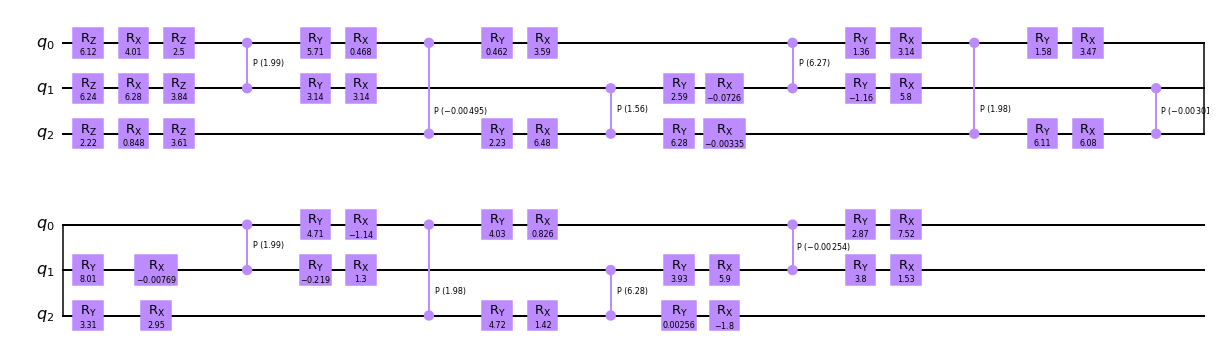

In [70]:
r = res[3]
print(r['loss'][-1])
anz.circuit(r['params'][-1]).draw(output='mpl')